# Análise exploratória dos dados [NextGen energy storage](https://zenodo.org/records/14885589)

Um conjunto de dados sobre consumo de eletricidade residencial, geração solar em telhados e operações de bateria referente a 100 residências no Território da Capital Australiana (ACT), Austrália.

Os dados foram coletados e disponibilizados para uso pelo Governo do ACT através do programa *The Next Generation (Nextgen) Energy Storage*.

Os dados estão descritos neste artigo de conferência: [https://doi.org/10.1145/3307772.3331017](https://doi.org/10.1145/3307772.3331017) - *preprint* disponível em: [https://zenodo.org/records/14885676](https://zenodo.org/records/14885676)

**As colunas de dados são:**

* `index`: índice
* `load power (kW)`: potência da carga (consumo)
* `solar power (kW)`: potência solar
* `battery power (kW)`: potência da bateria
* `battery SoC (kWh)`: Estado de Carga (*State of Charge*) da bateria
* `solar capacity (kW)`: capacidade solar instalada
* `battery capacity (kWh)`: capacidade de energia da bateria
* `battery peak power (kW)`: potência de pico da bateria

**Referência:**
[1] B. Sturmberg e M. Shaw, “Select data from the NextGen energy storage trial in the ACT, Australia”. Zenodo, 11 de jun. de 2025. doi: [10.5281/zenodo.14885589.](https://doi.org/10.5281/zenodo.14885589)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# --- 1. CARREGAMENTO DOS DADOS ---
# Lista dos seus arquivos (Adicione ou remova conforme necessário)
files = [
    '../data/14885589/0-id_114.csv',
    # '../data/14885589/90-id_261.csv', # Descomente para adicionar mais casas
    # '../data/14885589/14-id_292.csv'
]

# Lê e concatena todos os arquivos da lista em um único DataFrame
# (Se você quiser analisar apenas um arquivo, deixe apenas um na lista acima)
df1 = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

# --- 2. LIMPEZA E FORMATAÇÃO ---
# Se 'original index' foi lido como índice (está em negrito à esquerda), resetamos para virar coluna
if 'original index' not in df1.columns:
    df1 = df1.reset_index()

# Renomeia a coluna de índice recém-criada (geralmente 'index' ou 'level_0') para o padrão
rename_map = {'index': 'original index', 'level_0': 'original index'}
df1 = df1.rename(columns=rename_map)

# Converte para Datetime (trata segundos Unix ou Strings automaticamente)
# errors='coerce' transforma valores inválidos em NaT (Not a Time) para não quebrar o código
df1['original index'] = pd.to_datetime(df1['original index'], unit='s', errors='coerce')

# Remove linhas onde a data não pôde ser convertida (se houver lixo no CSV)
df_clean = df1.dropna(subset=['original index']).copy()

# --- 3. ENGENHARIA DE ATRIBUTOS (Colunas Auxiliares) ---
# Extrai Mês e Data para agrupamento
df_clean['Month'] = df_clean['original index'].dt.month
df_clean['Date']  = df_clean['original index'].dt.date

# --- CRIAÇÃO DA COLUNA 'TIME_PLOT' ---
# Truque para o Matplotlib: Criamos uma data fictícia (01/01/2000) mas mantemos o horário original.
# Isso permite sobrepor curvas de dias diferentes no mesmo eixo X.
# Método otimizado: subtrai o dia atual e soma a data base fixa.
base_date = pd.Timestamp('2000-01-01')
df_clean['Time_Plot'] = df_clean['original index'].apply(
    lambda x: x.replace(year=base_date.year, month=base_date.month, day=base_date.day)
)

# Visualização de verificação
print("Preparação concluída!")
print(f"Dimensões do Dataset: {df_clean.shape}")
print("\nColunas disponíveis:")
print(df_clean.columns.tolist())
print("\nExemplo dos dados preparados:")
display(df_clean[['original index', 'Month', 'Time_Plot']].head())

Preparação concluída!
Dimensões do Dataset: (105120, 11)

Colunas disponíveis:
['original index', 'load power (kW)', 'solar power (kW)', 'battery power (kW)', 'battery SoC (kWh)', 'solar capacity (kW)', 'battery capacity (kWh)', 'battery peak power (kW)', 'Month', 'Date', 'Time_Plot']

Exemplo dos dados preparados:


original index  Month           Time_Plot
0 2017-12-31 13:00:00     12 2000-01-01 13:00:00
1 2017-12-31 13:05:00     12 2000-01-01 13:05:00
2 2017-12-31 13:10:00     12 2000-01-01 13:10:00
3 2017-12-31 13:15:00     12 2000-01-01 13:15:00
4 2017-12-31 13:20:00     12 2000-01-01 13:20:00

In [3]:
df_clean.columns

Index(['original index', 'load power (kW)', 'solar power (kW)',
       'battery power (kW)', 'battery SoC (kWh)', 'solar capacity (kW)',
       'battery capacity (kWh)', 'battery peak power (kW)', 'Month', 'Date',
       'Time_Plot'],
      dtype='object')

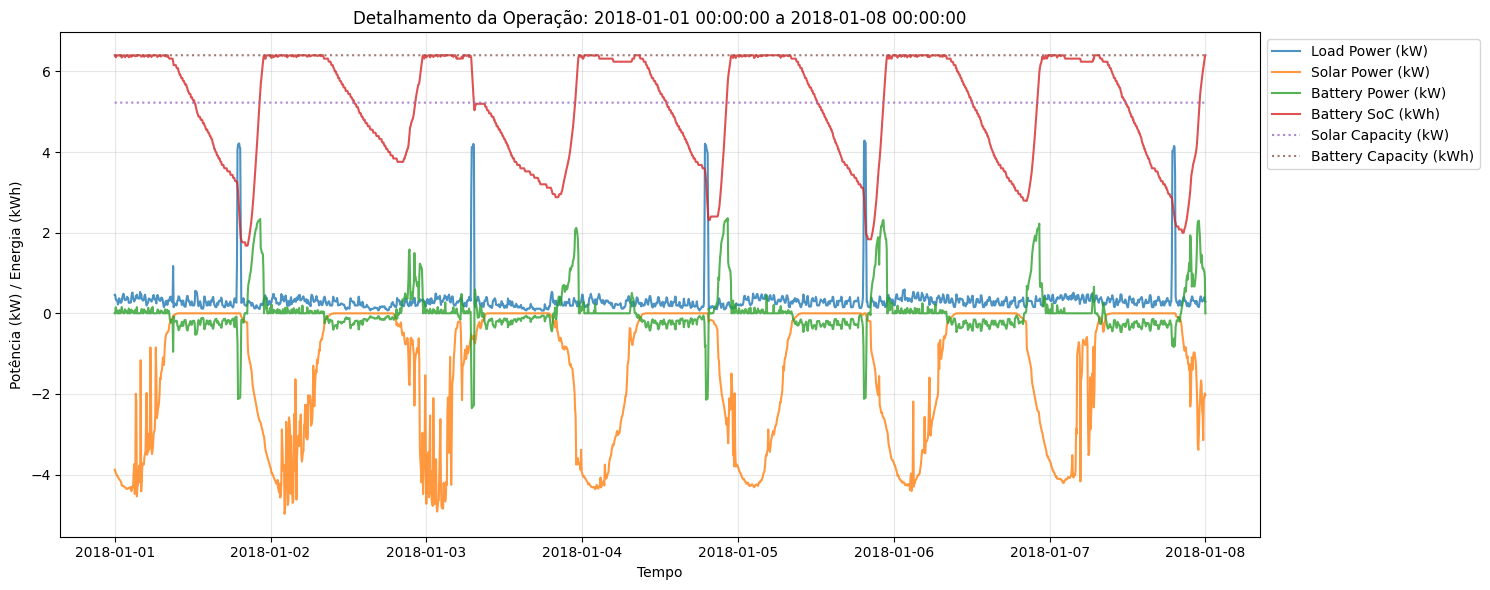

In [4]:
# --- CONFIGURAÇÃO DO INTERVALO ---
# Dica: Use strings no formato 'AAAA-MM-DD HH:MM' se quiser precisão de horas
start = "2018-01-01 00:00:00"
end   = "2018-01-08 00:00:00" # Aumentei um dia para pegar o intervalo cheio de 01 e 02/Jan

# --- FILTRAGEM ---
# Usando 'df_clean' que preparamos na célula anterior (garantia de datas corretas)
mask = (df_clean['original index'] >= start) & (df_clean['original index'] <= end)
df_window = df_clean.loc[mask]

# Verificação de segurança (caso o filtro retorne vazio)
if df_window.empty:
    print(f"Aviso: Nenhum dado encontrado entre {start} e {end}.")
    print(f"Data mínima disponível: {df_clean['original index'].min()}")
    print(f"Data máxima disponível: {df_clean['original index'].max()}")
else:
    # --- PLOTAGEM ---
    fig, axe = plt.subplots(figsize=(15, 6)) # Aumentei um pouco a altura

    # Plotando as curvas
    axe.plot(df_window['original index'], df_window['load power (kW)'], alpha=0.8, label='Load Power (kW)')
    axe.plot(df_window['original index'], df_window['solar power (kW)'], alpha=0.8, label='Solar Power (kW)')
    axe.plot(df_window['original index'], df_window['battery power (kW)'], alpha=0.8, label='Battery Power (kW)')
    axe.plot(df_window['original index'], df_window['battery SoC (kWh)'], alpha=0.8, label='Battery SoC (kWh)')
    
    # As colunas de capacidade são linhas retas constantes, mas vale plotar para referência
    if 'solar capacity (kW)' in df_window.columns:
        axe.plot(df_window['original index'], df_window['solar capacity (kW)'], alpha=0.8, linestyle=':', label='Solar Capacity (kW)')
    if 'battery capacity (kWh)' in df_window.columns:
        axe.plot(df_window['original index'], df_window['battery capacity (kWh)'], alpha=0.8, linestyle=':', label='Battery Capacity (kWh)')

    # Estética
    axe.legend(loc='upper left', bbox_to_anchor=(1, 1)) # Legenda fora para não cobrir o gráfico
    axe.set_xlabel('Tempo')
    axe.set_ylabel('Potência (kW) / Energia (kWh)')
    axe.set_title(f'Detalhamento da Operação: {start} a {end}')
    axe.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [10]:
def plot_seasonal_grid(df, col_to_plot, unit='kW', color='tab:blue'):
    """
    Gera uma grade 3x4 (mensal) com o perfil diário de 'col_to_plot'.
    
    Args:
        df (pd.DataFrame): DataFrame contendo 'original index' e a coluna de dados.
        col_to_plot (str): Nome da coluna a ser analisada (ex: 'solar power (kW)').
        unit (str): Unidade para o eixo Y.
        color (str): Cor das linhas dos dias (padrão: azul).
    """
    
    # 1. Trabalhar com uma cópia para não alterar o dataframe original fora da função
    df_clean = df.copy()
    
    # 2. Preparação dos Dados (Cria as colunas se não existirem)
    if 'Month' not in df_clean.columns:
        df_clean['Month'] = df_clean['original index'].dt.month
        
    if 'Date' not in df_clean.columns:
        df_clean['Date'] = df_clean['original index'].dt.date
        
    if 'Time_Plot' not in df_clean.columns:
        # Método otimizado para criar a data fictícia (mais rápido que strftime para muitos dados)
        base_date = pd.Timestamp('2000-01-01')
        df_clean['Time_Plot'] = df_clean['original index'].apply(
            lambda x: x.replace(year=base_date.year, month=base_date.month, day=base_date.day)
        )

    months = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']

    # 3. Configuração da Grade 3x4
    fig, axes = plt.subplots(3, 4, figsize=(20, 12), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        month_num = i + 1
        
        # Filtrar apenas o mês atual
        df_month = df_clean[df_clean['Month'] == month_num]
        
        if not df_month.empty:
            # Pivotagem: Transforma cada dia em uma coluna
            pivot_view = df_month.pivot_table(index='Time_Plot', columns='Date', values=col_to_plot, aggfunc='mean')
            
            # Plotar as linhas individuais (Dias)
            ax.plot(pivot_view.index, pivot_view.values, color=color, alpha=0.3, linewidth=1)
            
            # Plotar a Média
            mean_curve = pivot_view.mean(axis=1)
            ax.plot(mean_curve.index, mean_curve.values, color='black', linewidth=1.5, linestyle='--', label='Média')

        # Estética do Subplot
        ax.set_title(f"{months[i]}")
        ax.grid(True, alpha=0.3)
        
        # Formatar Eixo X (Hora:Minuto)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    # 4. Ajustes Finais Globais
    # Legenda apenas no primeiro gráfico
    axes[0].legend(loc='upper right', fontsize='small')

    # Ticks manuais para garantir limpeza (00h, 06h, 12h, 18h)
    xticks_vals = [pd.Timestamp(f'2000-01-01 {h:02d}:00:00') for h in [0, 6, 12, 18]]
    plt.setp(axes, xticks=xticks_vals)

    fig.suptitle(f'Perfil Diário: {col_to_plot} - Variação Mensal', fontsize=16)
    fig.text(0.5, 0.04, 'Hora do Dia', ha='center', fontsize=12)
    fig.text(0.04, 0.5, f'Potência / Energia ({unit})', va='center', rotation='vertical', fontsize=12)

    plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
    plt.show()


In [11]:
df_clean.columns

Index(['original index', 'load power (kW)', 'solar power (kW)',
       'battery power (kW)', 'battery SoC (kWh)', 'solar capacity (kW)',
       'battery capacity (kWh)', 'battery peak power (kW)', 'Month', 'Date',
       'Time_Plot'],
      dtype='object')

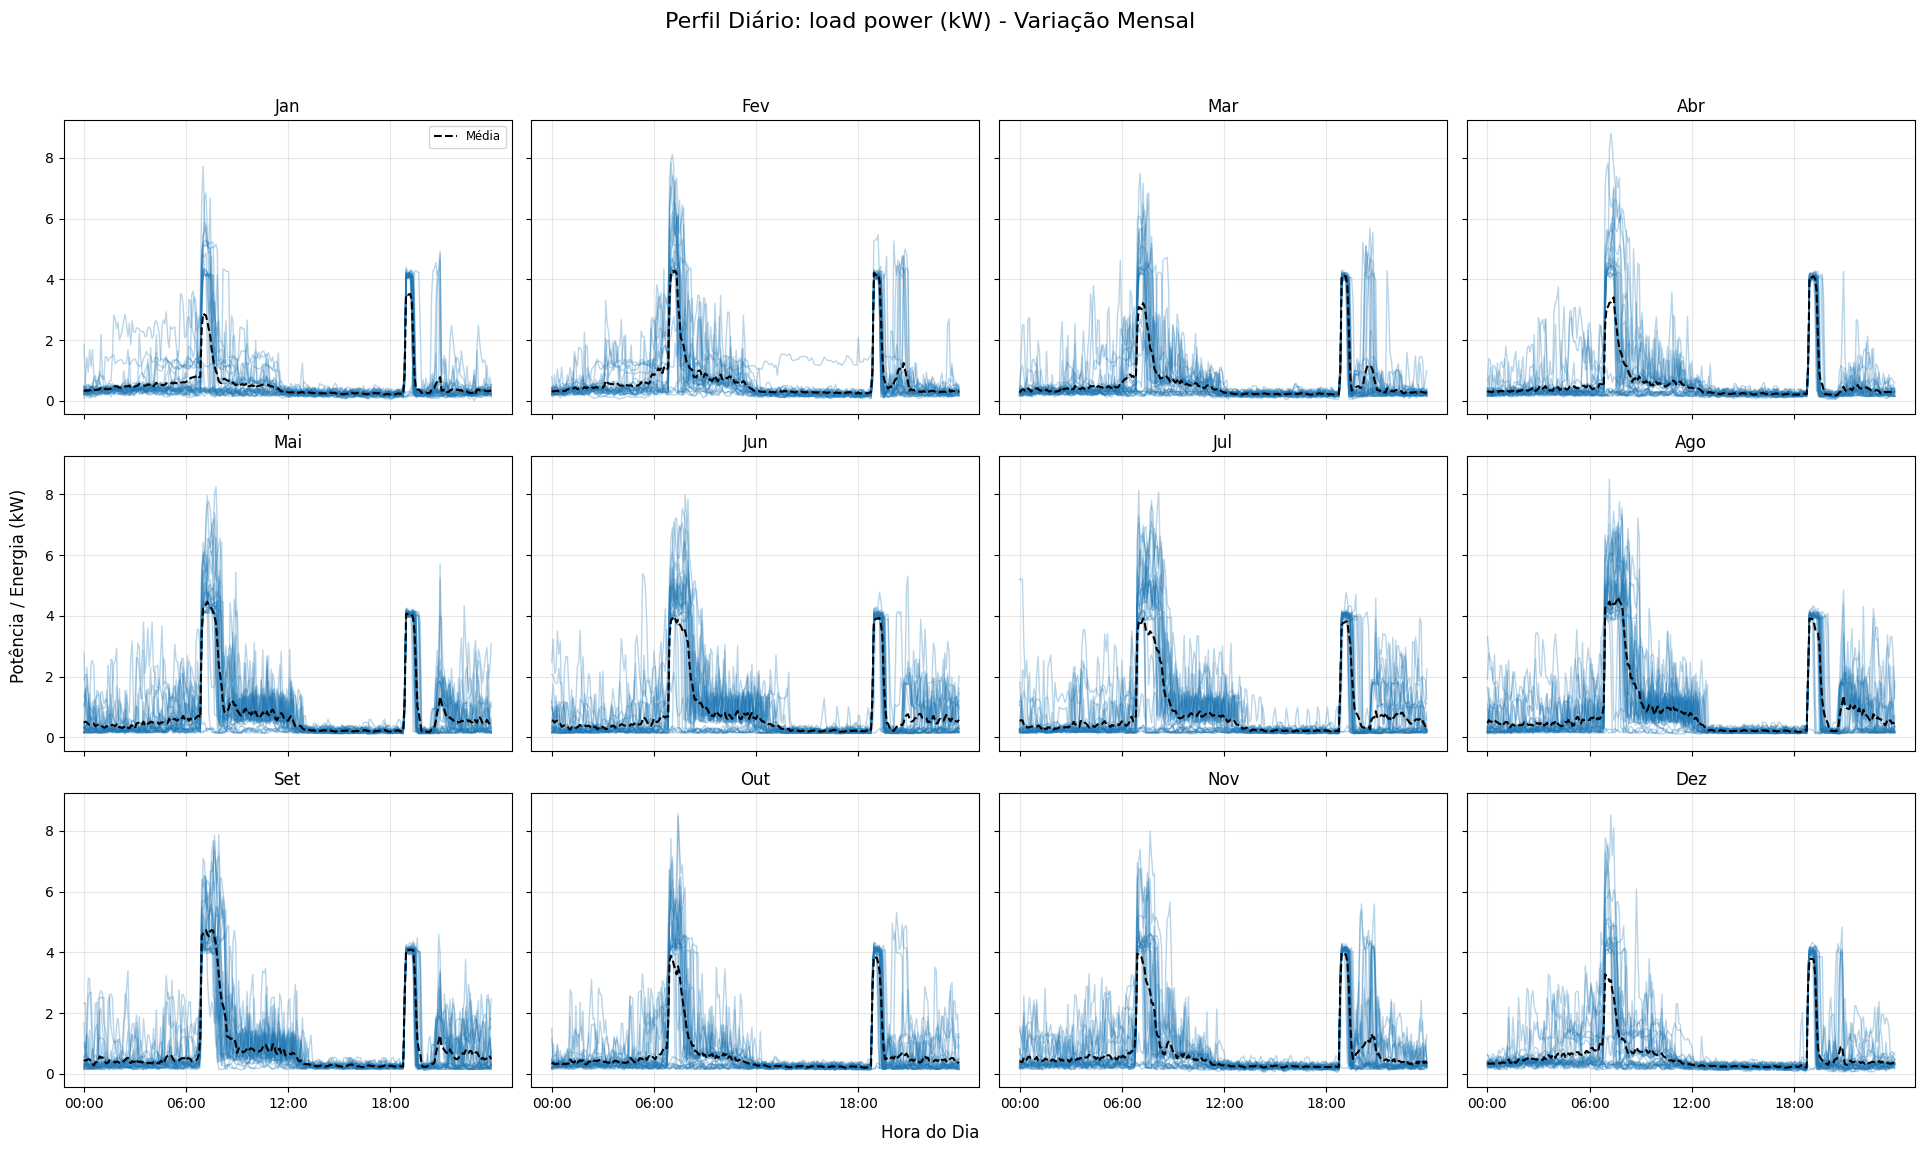

In [12]:
# Para Energia Solar (Azul)
plot_seasonal_grid(df_clean, 'load power (kW)', unit='kW', color='tab:blue')

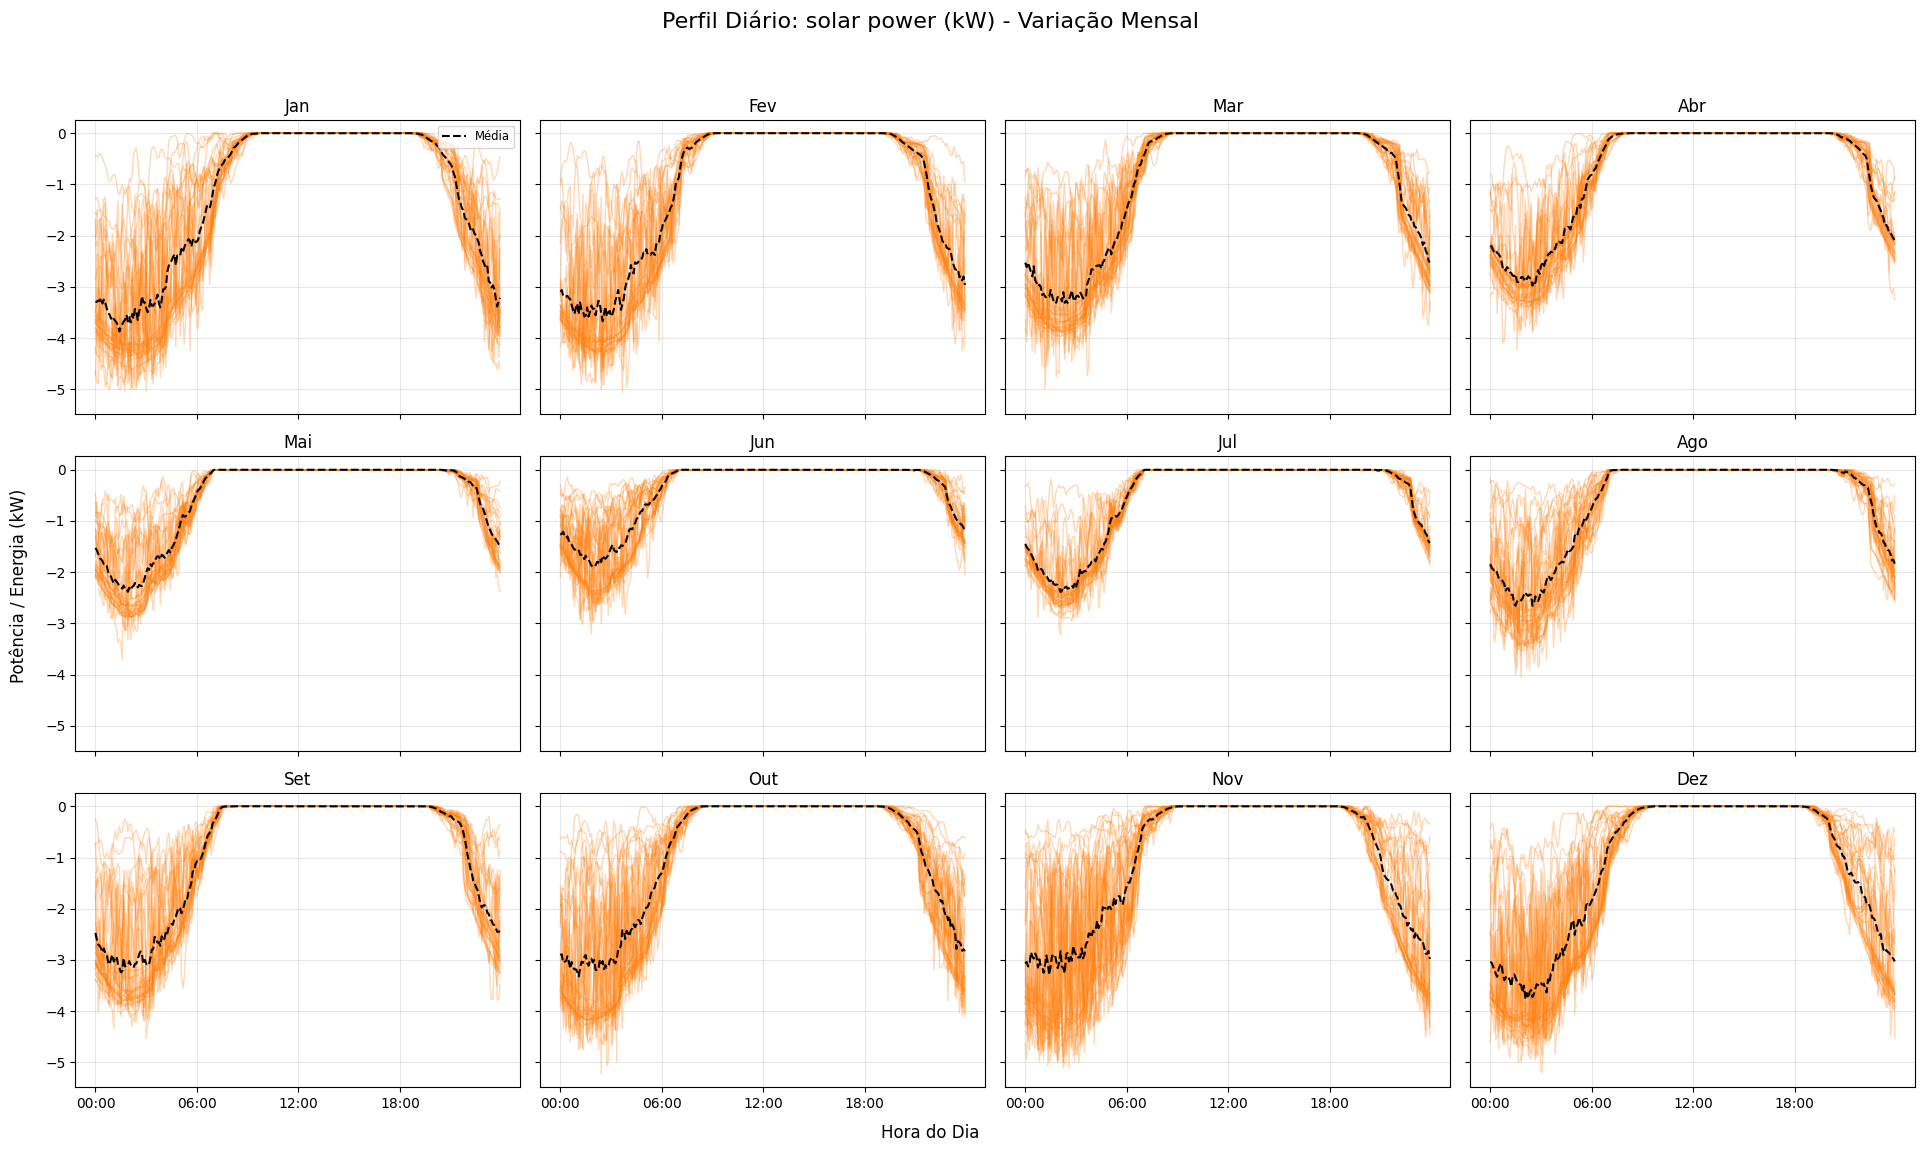

In [13]:
# Para Carga/Consumo (Laranja)
plot_seasonal_grid(df_clean, 'solar power (kW)', unit='kW', color='tab:orange')

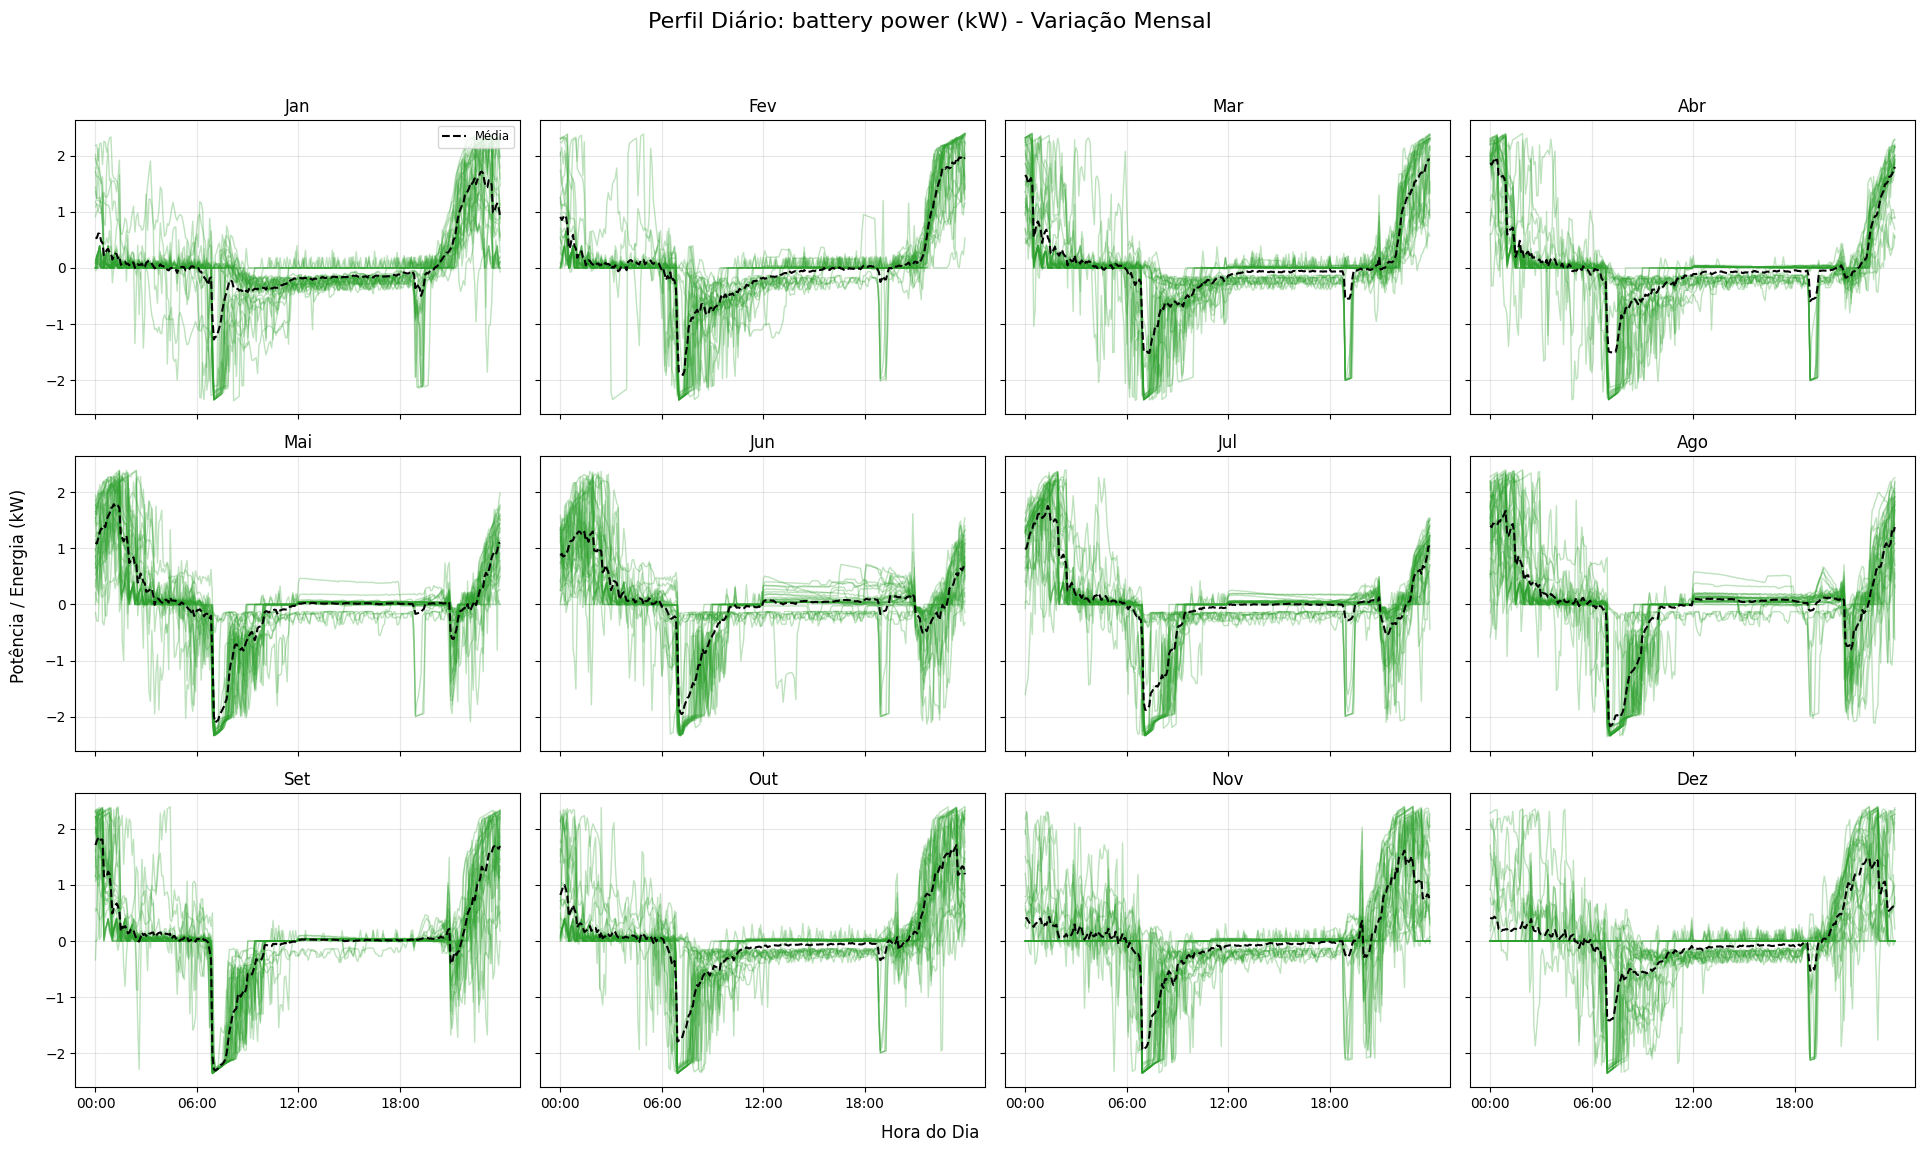

In [14]:
# Para Bateria (Verde)
plot_seasonal_grid(df_clean, 'battery power (kW)', unit='kW', color='tab:green')

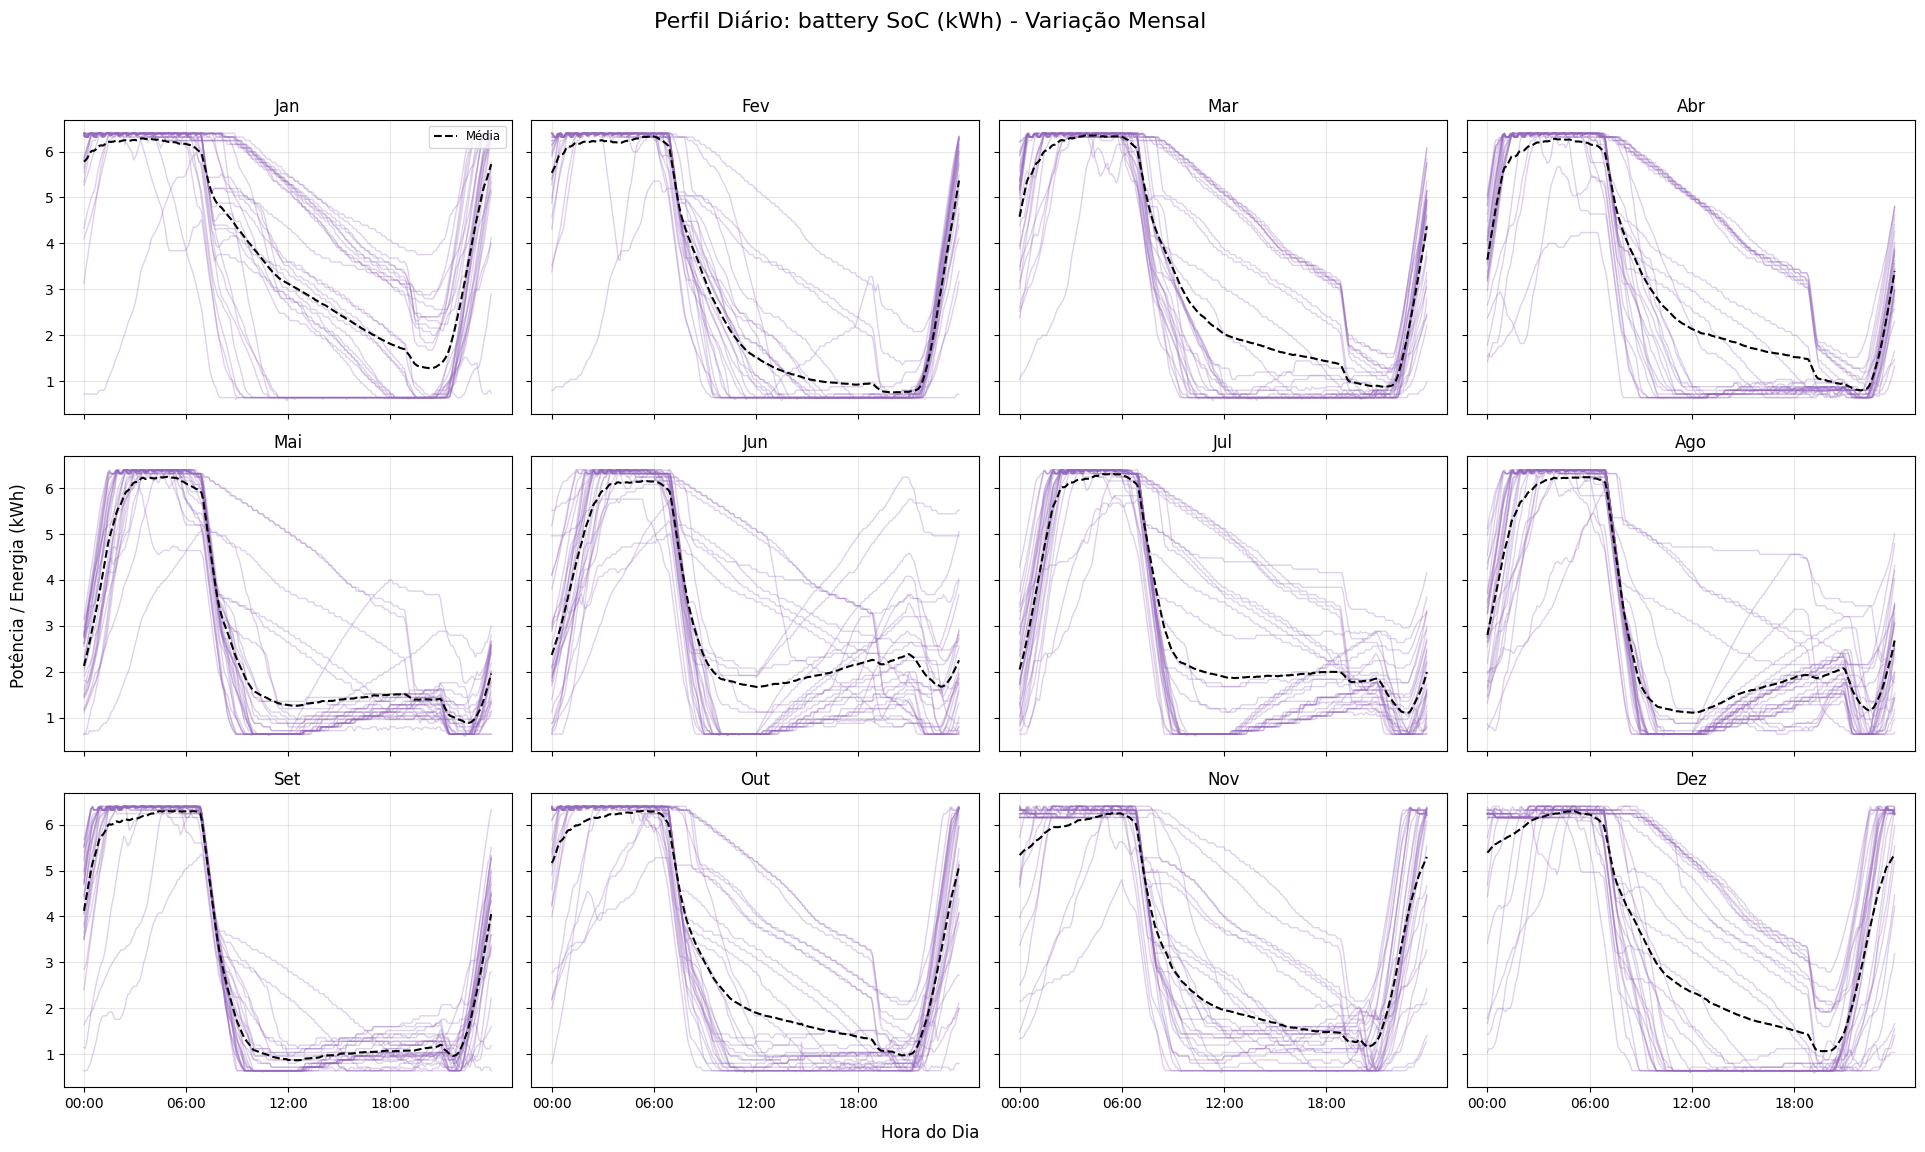

In [15]:
# Para Bateria SoC (Roxo)
plot_seasonal_grid(df_clean, 'battery SoC (kWh)', unit='kWh', color='tab:purple')